# [0.4] - Build Your Own Backpropagation Framework (exercises)

> **ARENA [Streamlit Page](https://arena-chapter0-fundamentals.streamlit.app/04_[0.4]_Backprop)**
>
> **Colab: [exercises](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter0_fundamentals/exercises/part4_backprop/0.4_Backprop_exercises.ipynb?t=20250910) | [solutions](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter0_fundamentals/exercises/part4_backprop/0.4_Backprop_solutions.ipynb?t=20250910)**

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-uk/shared_invite/zt-3afdmdhye-Mdb3Sv~ss_V_mEaXEbkABA), and ask any questions on the dedicated channels for this chapter of material.

You can collapse each section so only the headers are visible, by clicking the arrow symbol on the left hand side of the markdown header cells.

Links to all other chapters: [(0) Fundamentals](https://arena-chapter0-fundamentals.streamlit.app/), [(1) Transformer Interpretability](https://arena-chapter1-transformer-interp.streamlit.app/), [(2) RL](https://arena-chapter2-rl.streamlit.app/).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/headers/header-04.png" width="350">

# Introduction

Today you're going to build your very own system that can run the backpropagation algorithm in essentially the same way as PyTorch does. By the end of the day, you'll be able to train a multi-layer perceptron neural network, using your own backprop system!

The main differences between the full PyTorch and our version are:

* We will focus on CPU only, as all the ideas are the same on GPU.
* We will use NumPy arrays internally instead of ATen, the C++ array type used by PyTorch. Backpropagation works independently of the array type.
* A real `torch.Tensor` has about 700 fields and methods. We will only implement a subset that are particularly instructional and/or necessary to train the MLP.

Note - for today, I'd lean a lot more towards being willing to read the solutions, and even move on from some of them if you don't fully understand them (especially in the first half of section 3). The low-level messy implementation details for today are much less important than the high-level conceptual takeaways.

For a lecture on the material today, which provides some high-level understanding before you dive into the material, watch the video below:

<iframe width="540" height="304" src="https://www.youtube.com/embed/-24lS-kk5I0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Content & Learning Objectives

### 1️⃣ Introduction to backprop

This takes you through what a **computational graph** is, and the basics of how gradients can be backpropagated through such a graph. You'll also implement the backwards versions of some basic functions: if we have tensors `output = func(input)`, then the backward function of `func` can calculate the grad of `input` as a function of the grad of `output`.

> ##### Learning Objectives
>
> * Understand what a computational graph is, and how it can be used to calculate gradients.
> * Start to implement backwards versions of some basic functions.

### 2️⃣ Autograd

This section goes into more detail on the backpropagation methodology. In order to find the `grad` of each tensor in a computational graph, we first have to perform a **topological sort** of the tensors in the graph, so that each time we try to calculate `tensor.grad`, we've already computed all the other gradients which are used in this calculation. We end this section by writing a `backprop` function, which works just like the `tensor.backward()` method you're already used to in PyTorch.

> ##### Learning Objectives
>
> * Perform a topological sort of a computational graph (and understand why this is important).
> * Implement a the `backprop` function, to calculate and store gradients for all tensors in a computational graph.

### 3️⃣ Training on MNIST from scratch

In this section, we build your own equivalents of `torch.nn` features like `nn.Parameter`, `nn.Module`, and `nn.Linear`. We can then use these to build our own neural network to classify MINST data.

This completes the chain which starts at basic numpy arrays, and ends with us being able to build essentially any neural network architecture we want!

> ##### Learning Objectives
>
> * Implement more forward and backward functions, including for indexing, summing, and matrix multiplication
> * Learn how to build higher-level abstractions like parameters and modules on top of individual functions and tensors
> * Complete the process of building up a neural network from scratch and training it via gradient descent.

### 4️⃣ Bonus

A few bonus exercises are suggested, for pushing your understanding of backpropagation further.

## Setup code

In [1]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter0_fundamentals"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import jaxtyping
except:
    %pip install einops jaxtyping

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.3 MB/s eta 0:00:00
--2025-11-02 21:05:29--  https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main [following]
--2025-11-02 21:05:29--  https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/main.zip’

main.zip                [                <=> ]  21.33M  6.09MB/s    in 3.5s    

2025-11-02 21:05:33 (6.09 MB/s) - ‘/content/main.zip’ saved [22370544]

Archive:  /content/main.z

In [2]:
import os
import re
import sys
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Callable, Iterable, Iterator

import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

Arr = np.ndarray
grad_tracking_enabled = True

# Make sure exercises are in the path
chapter = "chapter0_fundamentals"
section = "part4_backprop"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section
if str(exercises_dir) not in sys.path:
    sys.path.append(str(exercises_dir))


import part4_backprop.tests as tests
from part4_backprop.utils import get_mnist, visualize
from plotly_utils import line

<details>
<summary>Help - I get a NumPy-related error</summary>

This is an annoying colab-related issue which I haven't been able to find a satisfying fix for. If you restart runtime (but don't delete runtime), and run just the imports cell above again (but not the `%pip install` cell), the problem should go away.
</details>

# 1️⃣ Introduction to backprop

> ##### Learning Objectives
>
> * Understand what a computational graph is, and how it can be used to calculate gradients.
> * Start to implement backwards versions of some basic functions.

## Reading

* [Calculus on Computational Graphs: Backpropagation (Chris Olah)](https://colah.github.io/posts/2015-08-Backprop/)

## Computing Gradients with Backpropagation

This section will briefly review the backpropagation algorithm, but focus mainly on the concrete implementation in software.

To train a neural network, we want to know how the loss would change if we slightly adjust one of the learnable parameters.

One obvious and straightforward way to do this would be just to add a small value  to the parameter, and run the forward pass again. This is called finite differences, and the main issue is we need to run a forward pass for every single parameter that we want to adjust. This method is infeasible for large networks, but it's important to know as a way of sanity checking other methods.

A second obvious way is to write out the function for the entire network, and then symbolically take the gradient to obtain a symbolic expression for the gradient. This also works and is another thing to check against, but the expression gets quite complicated.

Suppose that you have some **computational graph**, and you want to determine the derivative of the some scalar loss L with respect to NumPy arrays a, b, and c:

<img src="https://raw.githubusercontent.com/callummcdougall/Fundamentals/main/images/abc_de_L.png" width="400">

This graph corresponds to the following Python:

```python
d = a * b
e = b + c
L = d + e
```

The goal of our system is that users can write ordinary looking Python code like this and have all the book-keeping needed to perform backpropagation happen behind the scenes. To do this, we're going to wrap each array and each function in special objects from our library that do the usual thing plus build up this graph structure that we need.

### Backward Functions

We've drawn our computation graph from left to right and the arrows pointing to the right, so that in the forward pass, boxes to the right depend on boxes to the left. In the backwards pass, the opposite is true: the gradient of boxes on the left depends on the gradient of boxes on the right.

If we want to compute the derivative of $L$ wrt all other variables (as was described in the reading), we should traverse the graph from right to left. Each time we encounter an instance of function application, we can use the chain rule from calculus to proceed one step further to the left. For example, if we have $d = a \times b$, then:

$$
\frac{dL}{da} = \frac{dL}{dd}\times \frac{dd}{da} = \frac{dL}{dd}\times b
$$

Suppose we are working from right to left, trying to calculate $\frac{dL}{da}$. If we already know the values of the variables $a$, $b$ and $d$, as well as the value of $\frac{dL}{dd}$, then we can use the following function to find $\frac{dL}{da}$:

$$
F\left(a, b, d, \frac{dL}{dd}\right) = \frac{dL}{dd}\times b
$$

and we can do something similar when trying to calculate $\frac{dL}{db}$.

In other words, we can take the **"forward function"** $(a, b) \to a \cdot b$, and for each of its parameters, we can define an associated **"backwards function"** which tells us how to compute the gradient wrt this argument using only known quantities as inputs.

Ignoring issues of unbroadcasting (which we'll cover later), we could write the backward with respect to the first argument as:

```python
def multiply_back(grad_out, out, a, b):
    '''
    Inputs:
        grad_out = dL/d(out)
        out = a * b

    Returns:
        dL/da
    '''
    return grad_out * b
```

where `grad_out` is the gradient of the loss of the function with respect to the output (i.e. $\frac{dL}{dd}$), `out` is the output of the function (i.e. $d$), and `a` and `b` are our inputs.

### Topological Ordering

When we're actually doing backprop, how do we guarantee that we'll always know the value of our backwards functions' inputs? For instance, in the example above we couldn't have computed $\frac{dL}{da}$ without first knowing $\frac{dL}{dd}$.

The answer is that we sort all our nodes using an algorithm called [topological sorting](https://en.wikipedia.org/wiki/Topological_sorting), and then do our computations in this order. After each computation, we store the gradients in our nodes for use in subsequent calculations.

When described in terms of the diagram above, topological sort can be thought of as an ordering of nodes from right to left. Crucially, this sorting has the following property: if there is a directed path in the computational graph going from node `x` to node `y`, then `x` must follow `y` in the sorting.

There are many ways of proving that a cycle-free directed graph contains a topological ordering. You can try and prove this for yourself, or click on the expander below to reveal the outline of a simple proof.

<details>
<summary>Click to reveal proof</summary>

We can prove by induction on the number of nodes $N$.
    
If $N=1$, the problem is trivial.

If $N>1$, then pick any node, and follow the arrows until you reach a node with no directed arrows going out of it. Such a node must exist, or else you would be following the arrows forever, and you'd eventually return to a node you previously visited, but this would be a cycle, which is a contradiction. Once you've found this "root node", you can put it first in your topological ordering, then remove it from the graph and apply the topological sort on the subgraph created by removing this node. By induction, your topological sorting algorithm on this smaller graph should return a valid ordering. If you append the root node to the start of this ordering, you have a topological ordering for the whole graph.
</details>

A quick note on some potentially confusing terminology. We will refer to the "end node" as the **root node**, and the "starting nodes" as **leaf nodes**. For instance, in the diagram at the top of the section, the left nodes `a`, `b` and `c` are the leaf nodes, and `L` is the root node. This might seem odd given it makes the leaf nodes come before the root nodes, but the reason is as follows: *when we're doing the backpropagation algorithm, we start at `L` and work our way back through the graph*. So, by our notation, we start at the root node and work our way out to the leaves.

Another important piece of terminology here is **parent node**. This means the same thing as it does in most other contexts - the parents of node `x` are all the nodes `y` with connections `y -> x` (so in the diagram, `L`'s parents are `d` and `e`).

<details>
<summary>Question - can you think of a reason it might be important for a node to store a list of all of its parent nodes?</summary>

During backprop, we're moving from right to left in the diagram. If a node doesn't store its parent, then there will be no way to get access to that parent node during backprop, so we can't propagate gradients to it.
</details>

The very first node in our topological sort will be $L$, the root node.

### Backpropagation

After all this setup, the backpropagation mechanism becomes pretty straightforward. We sort the nodes topologically, then we iterate over them and call each backward function exactly once in order to accumulate the gradients at each node.

It's important that the grads be accumulated instead of overwritten in a case like value $b$ which has two outgoing edges, since $\frac{dL}{db}$ will then be the sum of two terms. Since addition is commutative it doesn't matter whether we `backward()` the Mul or the Add that depend on $b$ first.

During backpropagation, for each forward function in our computational graph we need to find the partial derivative of the output with respect to each of its inputs. Each partial is then multiplied by the gradient of the loss with respect to the forward functions output (`grad_out`) to find the gradient of the loss with respect to each input. We'll handle these calculations using backward functions.

## Backward function of log

First, we'll write the backward function for `x -> out = log(x)`. This should be a function which, when fed the values `x, out, grad_out = dL/d(out)` returns the value of `dL/dx` just from this particular computational path.

<img src="https://raw.githubusercontent.com/callummcdougall/Fundamentals/main/images/x_log_out.png" width="400">

Note - it might seem strange at first why we need `x` and `out` to be inputs, `out` can be calculated directly from `x`. The answer is that sometimes it is computationally cheaper to express the derivative in terms of `out` than in terms of `x`.

<details>
<summary>Question - can you think of an example function where it would be computationally cheaper to use 'out' than to use 'x'?</summary>

The most obvious answer is the exponential function, `out = e ^ x`. Here, the gradient `d(out)/dx` is equal to `out`. We'll see this when we implement a backward version of `torch.exp` later today.
</details>

### Exercise - implement `log_back`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

You should fill in this function below. Don't worry about division by zero or other edge cases - the goal here is just to see how the pieces of the system fit together.

*This should just be a short, one-line function.*

In [9]:
def log_back(grad_out: Arr, out: Arr, x: Arr) -> Arr:
    """Backwards function for f(x) = log(x)

    grad_out: Gradient of some loss wrt out
    out: the output of np.log(x).
    x: the input of np.log.

    Return: gradient of the given loss wrt x
    """
    return grad_out / x


tests.test_log_back(log_back)

All tests in `test_log_back` passed!


## Backward functions of two tensors

Now we'll implement backward functions for multiple tensors. From this point onwards, we'll be working with vector-valued derivatives, i.e. terms like $\frac{\partial x}{\partial y}$ where $y$ (and possibly $x$) are tensors. To recap what this notation means - these terms are tensors where each value is the scalar derivative of one of the elements of $x$ wrt one of the elements of $y$. For example:

- If $x$ is a scalar and $y$ is a tensor with shape `(3, 4)`, then $\frac{\partial x}{\partial y}$ is a tensor with shape `(3, 4)` where the `[i, j]`-th element is $\frac{\partial x}{\partial y[i, j]}$, i.e. the derivative of $x$ wrt a particular element of $y$.
- If $x$ is a length-5 vector and $y$ is a tensor with shape `(3, 4)` then $\frac{\partial x}{\partial y}$ is a tensor with shape `(5, 3, 4)` where the `[i, j, k]`-th element is $\frac{\partial x[i]}{\partial y[j, k]}$.

### Broadcasting

Before we go through the next exercises, we'll need to address one important topic in tensor operations - **broadcasting**. We've discussed it in earlier exercises, but we're reviewing it here because it's very important for backprop. If you're comfortable with the topic, feel free to jump forwards to the section "Why do we need broadcasting for backprop?".

Both NumPy and PyTorch have the same rules for broadcasting. When two tensors are involved in an elementwise operation, NumPy/PyTorch tries to broadcast them (i.e. copying them along dimensions) so that they both have the same shape. The rules of broadcasting are as follows:

1. You can prepend dummy dimensions (of size 1) to the start of a tensor until both have the same number of dimensions
2. After this point, if some dimension has size 1 in one of the tensors, it can be repeated until it matches the size of the corresponding dimension in the other tensor

To give a simple example - suppose we have a 2D batch of data, of shape `data.shape = (N, k)` (i.e. we have `N` separate datapoints, each being a vector of length `k`). Suppose we want to add a vector `vec` of length `k` to each datapoint. This is a valid operation, because when we try and add these two objects together:

1. `vec` gets prepended with a dummy dimension so it has shape `(1, k)` and both are 2D
2. `vec` gets repeated along the first dimension so it has shape `(N, k)`, matching the shape of `data`

Then, our output has shape `(N, k)`, and elements `output[i, j] = data[i, j] + vec[j]`.

Broadcasting can be a very easy place to make mistakes, because it's easy to lose track of the exact shape of your tensors involved. As a warm-up exercise, below are some examples of broadcasting. Can you figure out which are valid, and which will raise errors?


```python
x = np.ones((3, 1, 5))
y = np.ones((1, 4, 5))

z = x + y
```

<details>
<summary>Answer</summary>

This is valid, because the 0th dimension of `y` and the 1st dimension of `x` can both be copied so that `x` and `y` have the same shape: `(3, 4, 5)`. The resulting array `z` will also have shape `(3, 4, 5)`.

This example illustrates an important point - it's not always the case that one of the tensors is strictly smaller and the other is strictly bigger. Sometimes, both tensors will get expanded.

</details>

```python
x = np.ones((8, 2, 6))
y = np.ones((8, 2))

z = x + y
```

<details>
<summary>Answer</summary>

This is not valid. We first need to expand `y` by appending a dimension to the front, and the last two dimensions of `x` are `(2, 6)`, which won't broadcast with `y`'s `(8, 2)`.
</details>

```python
x = np.ones((8, 2, 6))
y = np.ones((2, 6))

z = x + y
```

<details>
<summary>Answer</summary>

This is valid. Once NumPy expands `y` by appending a single dimension to the front, it can then be broadcast with `x`.
</details>

```python
x = np.ones((10, 20, 30))
y = np.ones((20, 1))

z = x + y
```

<details>
<summary>Answer</summary>

This is valid. Once NumPy expands `y` by appending a single dimension to the front, it can then be broadcast with `x` (this will involve copying along the first and last dimensions).
</details>

```python
x = np.ones((4, 1))
y = np.ones((4,))

z = x + y
```

<details>
<summary>Answer</summary>

This is valid. Numpy will expand the second one to `(1, 4)` then broadcast them both to `(4, 4)`.

Although this won't raise an error, it's very possible that this isn't what the person adding these two arrays intended. A common source of mistakes is when you add 2 tensors thinking they're the same shape, but one actually has a dummy dimension you forgot about. Sadly this is something you'll just have to be vigilant for (e.g. adding assert statements where necessary, or making sure you aren't combining too many different tensor operations in a single line), because PyTorch doesn't have built-in ways of statically checking your tensor shapes.

</details>

### Why do we need broadcasting for backprop?

Often, operations like `out = f(x, y)` involve an implicit broadcasting step. For example, if `out = x + y` with `x.shape = (4,)` and `y.shape = (3, 4)`, then really our operation has 2 steps:

1. Broadcast `x` to a broadcasted version `x_b` which has the shape of `y`, i.e. copy it along the zeroth dimension to have shape `(3, 4)`,
2. Define `out = x_b + y`, which is an operation that doesn't involve broadcasting.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/broadcast-last-1.png" width="600">

How can we go from the gradient `dL/d(x_b)` (which might be easy to compute given it involves no broadcasting) to the gradient of `dL/dx`? The answer is that **we take `dL/d(x_b)` and sum it over the dimensions along which `x` was broadcasted to get `dL/dx`.**

For the mathematically inclined this can be proved fairly easily (we provide a sketch of the proof below). But let's focus on the intuition here. When we copy `x` along axes to create `x_b`, we're essentially creating multiple pathways for each element of `x` to affect the final loss: one path for each time the element of `x` was copied. So when we change some element of `x`, this causes a first-order change in the loss from all of these different pathways, and we have to sum these changes to get the total first-order change (i.e. the derivative). For example:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/broadcast-last-2.png" width="540">

> ##### Summary
>
> If we know $\frac{\partial L}{\partial (\mathbf{out})}$, and want to know $\frac{\partial L}{\partial \mathbf{x}}$ (where $x$ was broadcasted to produce $\text{out}$) then there are two steps:
>
> 1. Compute $\frac{\partial L}{\partial \mathbf{x_b}}$ in the standard way, i.e. using one of your backward functions (assuming no broadcasting happened).
> 2. ***Unbroadcast*** $\frac{\partial L}{\partial \mathbf{x_b}}$, by summing it over the dimensions along which $\mathbf{x}$ was broadcasted.


<details>
<summary>Mathematical derivation (sketch)</summary>

We start with:

$$
\frac{\partial L}{\partial \mathbf{x}} = \sum_{i_1, i_2, ...} \frac{\partial L}{\partial x_b[i_1, i_2, ...]} \cdot \frac{\partial x_b[i_1, i_2, ...]}{\partial \mathbf{x}}
$$

using the chain rule. Next, we can use the fact that $\frac{\partial x_b[i_1, i_2, ...]}{\partial x[j_1, j_2, ...]}$ equals 0 everywhere except the indices where $x$ was broadcasted to produce $x_b$, where it equals 1. Therefore, this sum over indices $i_1, i_2, ...$ is equivalent to just summing $\frac{\partial L}{\partial x_b[i_1, i_2, ...]}$ over the repeated elements of $x$.

</details>

We used the term "unbroadcast" because the way that our tensor's shape changes will be the reverse of how it changed during broadcasting. If `x` was broadcasted from `(4,) -> (3, 4)`, then unbroadcasting will have to take a tensor of shape `(3, 4)` and sum over it to return a tensor of shape `(4,)`. Similarly, if `x` was broadcasted from `(1, 4) -> (3, 4)`, then we need to sum over the zeroth dimension, but leave it as a 2D tensor with a leading dummy dimension of size 1.

### Exercise - implement `unbroadcast`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-25 minutes on this exercise.
> This function can be quite fiddly - if you're stuck, read and understand the solution code instead.
> ```

The `unbroadcast` function below should take any value like $\frac{\partial L}{\partial x_b}$ and return $\frac{\partial L}{\partial x}$ (where the arguments `original` and `broadcasted` represent $x$ and $x_b$ respectively). In the same way that broadcasting `original` to the shape of `broadcasted` can be described as a 2-step process:

1. Extend dummy dimensions (size 1) of `original` to match the last dimensions of `broadcasted`,
2. Prepend dimensions to `original` until it has the same ndims as `broadcasted`,

the unbroadcasting process is the same process in reverse:

1. Sum over prepended dimensions of `broadcasted` until it has the same ndims as `original`,
2. Now they have the same ndims, sum over dimensions of `broadcasted` where `original` had size 1.

For example, if `original.shape = (3, 1)` and `broadcasted.shape = (1, 2, 3, 4)` then the broadcasting steps look like `(3, 1) -> (3, 4) -> (1, 2, 3, 4)` (copying along those dimensions at each step) and the unbroadcasting steps look like `(1, 2, 3, 4) -> (3, 4) -> (3, 1)` (summing over those dimensions at each step).

In [11]:
def unbroadcast(broadcasted: Arr, original: Arr) -> Arr:
    """
    Sum 'broadcasted' until it has the shape of 'original'.

    broadcasted: An array that was formerly of the same shape of 'original' and was expanded by
        broadcasting rules.
    """
    out = broadcasted

    # 1) Remove any leading broadcasted axes
    lead = out.ndim - original.ndim
    if lead > 0:
        out = out.sum(axis=tuple(range(lead)))

    # 2) For axes where original has size 1, sum along those axes
    for ax, (o_dim, r_dim) in enumerate(zip(out.shape, original.shape)):
        if r_dim == 1 and o_dim != 1:
            out = out.sum(axis=ax, keepdims=True)

    assert out.shape == original.shape
    return out

tests.test_unbroadcast(unbroadcast)

All tests in `test_unbroadcast` passed!


In [141]:
# (A) unbroadcast intuition
x = np.ones((2,1)) * 2
y = np.arange(1,4).reshape(1,3)
z = x * y                    # (2,3)
go = np.ones_like(z)
gx_should = go.sum(axis=1, keepdims=True)
gy_should = go.sum(axis=0, keepdims=True)
print("gx_should shape:", gx_should.shape, "gy_should shape:", gy_should.shape)

# (B) sum-back with non-scalar grad_out
a = Tensor(np.ones((2,5)), requires_grad=True)
b = a.sum(dim=1)             # shape (2,)
b.backward(np.array([2.,2.]))
print("a.grad shape:", a.grad.shape, " unique values:", np.unique(a.grad.array))


gx_should shape: (2, 1) gy_should shape: (1, 3)
a.grad shape: (2, 5)  unique values: [2.]


### Backward Function for Elementwise Multiply

Functions that are differentiable with respect to more than one input tensor are straightforward given that we already know how to handle broadcasting.

- We're going to have two backwards functions, one for each input argument.
- If the input arguments were broadcasted together to create a larger output, the incoming `grad_out` will be of the larger common broadcasted shape and we need to make use of `unbroadcast` from earlier to match the shape to the appropriate input argument.
- We'll want our backward function to work when one of the inputs is a float (as opposed to a tensor). We won't need to calculate the grad_in with respect to floats, so we only need to consider when y is a float for `multiply_back0` and when x is a float for `multiply_back1`.

### Exercise - implement both `multiply_back` functions

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 10-15 minutes on these exercises.
> ```

Below, you should implement both `multiply_back0` and `multiply_back1`.

You might be wondering why we need two different functions, rather than just having a single function to serve both purposes. This will become more important later on, once we deal with functions with more than one argument, which is not symmetric in its arguments. For instance, the derivative of $x / y$ wrt $x$ is not the same as the expression you get after differentiating this wrt $y$ then swapping the labels around.

The first part of each function has been provided for you (this makes sure that both inputs are arrays, since we want to support multiplication by floats or scalars).

In [12]:
def multiply_back0(grad_out: Arr, out: Arr, x: Arr, y: Arr | float) -> Arr:
    """Backward for z = x * y w.r.t. x."""
    if not isinstance(y, Arr):
        y = np.array(y, dtype=x.dtype)
    return unbroadcast(grad_out * y, x)


def multiply_back1(grad_out: Arr, out: Arr, x: Arr | float, y: Arr) -> Arr:
    """Backward for z = x * y w.r.t. y."""
    if not isinstance(x, Arr):
        x = np.array(x, dtype=y.dtype)
    return unbroadcast(grad_out * x, y)



tests.test_multiply_back(multiply_back0, multiply_back1)
tests.test_multiply_back_float(multiply_back0, multiply_back1)

All tests in `test_multiply_back` passed!
All tests in `test_multiply_back_float` passed!


Now we'll use our backward functions to do backpropagation manually, for the following computational graph:

<img src="https://raw.githubusercontent.com/callummcdougall/Fundamentals/main/images/abcdefg.png" width=550>

### Exercise - implement `forward_and_back`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 15-20 minutes on these exercises.
> This function is very useful for getting a sense for what backprop looks like in practice.
> ```

Below, you should implement the `forward_and_back` function. This is an opportunity for you to practice using the backward functions you've written so far, and should hopefully give you a better sense of how the full backprop function will eventually work.

Note - you might be wondering what `grad_out` should be the first time you call a backward function. We've so far assumed that the final node `L` in the computational graph is a scalar, and all gradients (i.e. the `grad_out` input to our backward functions and the output of our backward functions) are gradients of `L`. In this case, it would make sense to set `grad_out = [1]` for the first backward function call, since we're computing $\frac{\partial L}{\partial L} = 1$. But what about cases like the one above, when our final node `g` might not be a scalar?

The answer is that we effectively add a final scalar node into our graph, defined as `L = (g * v).sum()` for some tensor `v` of the same shape as `g`. This is called the **directional derivative**. We then compute all tensor gradients using `L` as our final node. For example, this means that in our first gradient calculation (where `g` is the output and `f` is the input) we'll use `grad_out = dL/dg = v`. You don't really need to worry about this, because most of the time (including in the exercise below) we'll just be using the default behaviour where `v` is a tensor of 1s - this is equivalent to `L = g.sum()`.

In [13]:
def forward_and_back(a: Arr, b: Arr, c: Arr) -> tuple[Arr, Arr, Arr]:
    """
    Calculates the output of the computational graph above (g), then backpropogates the gradients
    and returns dg/da, dg/db, and dg/dc.
    """
    d = a * b
    e = np.log(c)
    f = d * e
    g = np.log(f)
    final_grad_out = np.ones_like(g)

    # Backward
    df = log_back(final_grad_out, g, f)              # ∂g/∂f
    dd = multiply_back0(df, f, d, e)                 # ∂g/∂d
    de = multiply_back1(df, f, d, e)                 # ∂g/∂e
    dg_dc = log_back(de, e, c)                       # ∂g/∂c
    dg_da = multiply_back0(dd, d, a, b)              # ∂g/∂a
    dg_db = multiply_back1(dd, d, a, b)              # ∂g/∂b

    return (dg_da, dg_db, dg_dc)


tests.test_forward_and_back(forward_and_back)

All tests in `test_forward_and_back` passed!


In the next section, you'll build up to full automation of this backpropagation process, in a way that's similar to PyTorch's `autograd`.

# 2️⃣ Autograd

> ##### Learning Objectives
>
> * Perform a topological sort of a computational graph (and understand why this is important).
> * Implement a the `backprop` function, to calculate and store gradients for all tensors in a computational graph.

Now, rather than figuring out which backward functions to call, in what order, and what their inputs should be, we'll write code that takes care of that for us. We'll implement this with a few major components:

- `Tensor`, which is a wrapper around numpy arrays which is equivalent to PyTorch's `Tensor` class
- `Recipe`, which tracks the extra information needed to run backpropagation (mainly how this tensor was created from other tensors)
- `wrap_forward_fn`, which takes a numpy function mapping arrays to arrays (e.g. `np.log`) and returns a new function that maps tensors to tensors (while also creating the recipe for the new tensor)

## Wrapping Arrays (Tensor)

We're going to wrap each array with a wrapper object from our library which we'll call `Tensor` because it's going to behave similarly to a `torch.Tensor`.

Each Tensor that is created by one of our forward functions will have a `Recipe`, which tracks the extra information need to run backpropagation.

`wrap_forward_fn` will take a forward function and return a new forward function that does the same thing while recording the info we need to do backprop in the `Recipe`.

## Recipe

Let's start by taking a look at `Recipe`.

`@dataclass` is a handy class decorator that sets up an `__init__` function for the class that takes the provided attributes as arguments and sets them as you'd expect.

The class `Recipe` is designed to track the forward functions in our computational graph, so that gradients can be calculated during backprop. Each tensor created by a forward function has its own `Recipe`. We're naming it this because it is a set of instructions that tell us which ingredients went into making our tensor: what the function was, and what tensors were used as input to the function to produce this one as output.

In [14]:
@dataclass(frozen=True)
class Recipe:
    """Extra information necessary to run backpropagation. You don't need to modify this."""

    func: Callable
    "The 'inner' NumPy function that does the actual forward computation."
    "Note, we call it 'inner' to distinguish it from the wrapper we'll create for it later on."

    args: tuple
    "The input arguments passed to func."
    "For instance, if func=np.sum then args would be a length-1 tuple with the tensor to be summed."

    kwargs: dict[str, Any]
    "Keyword arguments passed to func."
    "For instance, if func was np.sum then kwargs might contain 'dim' and 'keepdims'."

    parents: dict[int, "Tensor"]
    "Map from positional argument index to the Tensor at that position."
    "For passing gradients back along the computational graph."

Note that `args` just stores the values of the underlying arrays, but `parents` stores the actual tensors. This is because they serve two different purposes: `args` is required for computing the value of gradients during backpropagation, and `parents` is required to infer the structure of the computational graph (i.e. which tensors were used to produce which other tensors).

Here are some examples, to build intuition for what the four fields of `Recipe` are, and why we need all four of them to fully describe a tensor in our graph and how it was created. Make sure you understand each of these examples before moving on, because it'll really help you progress quickly through the following exercises.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/recipe-v2.png" width="800">

## Registering backwards functions

The `Recipe` takes care of tracking the forward functions in our computational graph, but we still need a way to find the backward function corresponding to a given forward function when we do backprop (or possibly the set of backward functions, if the forward function takes more than one argument).

### Exercise - implement `BackwardFuncLookup`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on these exercises.
> These exercises should be very short, once you understand what is being asked.
> ```

We will define a class `BackwardFuncLookup` in order to find the backward function for a given forward function. The implementation details are left up to you - all that matters is that you pass the test code in the cell below. Reading this test code should explain how the `BackwardFuncLookup` class needs to be used - for any given forward function e.g. `np.log`, we need to be able to add a set of backward functions for each of its positional arguments.

In [15]:
class BackwardFuncLookup:
    def __init__(self) -> None:
        # Map (forward_fn, arg_position) -> back_fn
        self._table: dict[tuple[Callable, int], Callable] = {}

    def add_back_func(self, forward_fn: Callable, arg_position: int, back_fn: Callable) -> None:
        self._table[(forward_fn, arg_position)] = back_fn

    def get_back_func(self, forward_fn: Callable, arg_position: int) -> Callable:
        try:
            return self._table[(forward_fn, arg_position)]
        except KeyError as e:
            raise KeyError(f"No backward func registered for {forward_fn} at arg {arg_position}") from e



BACK_FUNCS = BackwardFuncLookup()

BACK_FUNCS.add_back_func(np.log, 0, log_back)
BACK_FUNCS.add_back_func(np.multiply, 0, multiply_back0)
BACK_FUNCS.add_back_func(np.multiply, 1, multiply_back1)

assert BACK_FUNCS.get_back_func(np.log, 0) == log_back
assert BACK_FUNCS.get_back_func(np.multiply, 0) == multiply_back0
assert BACK_FUNCS.get_back_func(np.multiply, 1) == multiply_back1

print("Tests passed - BackwardFuncLookup class is working as expected!")

Tests passed - BackwardFuncLookup class is working as expected!


## Tensors

Our Tensor object has these fields:

- An `array` field of type `np.ndarray`. These are the actual tensor values.
- A `requires_grad` field of type `bool`. This determines whether we need to compute gradients for this tensor (note this doesn't necessarily mean we need to store them, see below).
- A `grad` field of the same size and type as the value. This is where gradients are stored.
- A `recipe` field, as we've already seen. A tensor has a recipe if and only if it was created by some operation on other tensors.

### `requires_grad` and `is_leaf`

The meaning of `requires_grad` is that when doing operations using this tensor, the recipe will be stored and it and any descendents will be included in the computational graph. Note that `requires_grad` does not necessarily mean that we will save the accumulated gradients to this tensor's `.grad` parameter when doing backprop - for example we require gradients to propagate through the hidden activations of a neural network to get back to grads for our model weights, but we don't need to actually store the gradients of the hidden activations.

We use `is_leaf` to differentiate between these cases (see the method `Tensor.is_leaf` defined below) - a leaf tensor is one that represents the end of a backprop path, either because it doesn't require gradients or it has no nodes further back in the computational graph which require gradients. So our backprop algorithm will always terminate at a leaf node, then store that leaf node's gradient as `.grad` only if `requires_grad` is true.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/is_leaf.png" width="900">

You can investigate this by running the following code:

```python
layer = torch.nn.Linear(3, 4)
input = torch.ones(3)
output = layer(input)

print(layer.weight.is_leaf)       # -> True
print(layer.weight.requires_grad) # -> True

print(output.is_leaf)             # -> False
print(output.requires_grad)       # -> True

print(input.is_leaf)              # -> True
print(input.requires_grad)        # -> False
```

When creating tensors, we can set `requires_grad` explicitly (e.g. it's false by default for most tensors, but is true by default if that tensor is wrapped in `torch.nn.Parameter` - we'll create our own version of this later). When creating a tensor from another tensor or tensors, `requires_grad` is true if and only if all of the following 3 conditions hold:

1. Global grad tracking is enabled. In this notebook we've represented this with the global variable `grad_tracking_enabled`, but in PyTorch this is done with `torch.set_grad_enabled(False)`. This is useful because when you're looking at a model in inference mode, gradient tracking can waste memory and it's useful to disable it (we'll do this a lot next week, when we study transformer interpretability).
2. At least one of the input tensors requires grad (since this is equivalent to "there are other tensors further upstream which we need to get gradients for").
3. The function is differentiable (if not, obviously we can't compute gradients).

Now, we're giving you the full `Tensor` class. Most of these methods are currently undefined, and you'll go on to define them in later exercises (so you won't need to write any code this class). For now, just pay attention to the docstring & `__init__` methods.

In [16]:
Arr = np.ndarray


class Tensor:
    """
    A drop-in replacement for torch.Tensor supporting a subset of features.
    """

    array: Arr
    "The underlying array. Can be shared between multiple Tensors."
    requires_grad: bool
    "If True, calling functions or methods on this tensor will track relevant data for backprop."
    grad: "Tensor | None"
    "Backpropagation will accumulate gradients into this field."
    recipe: "Recipe | None"
    "Extra information necessary to run backpropagation."

    def __init__(self, array: Arr | list, requires_grad=False):
        self.array = array if isinstance(array, Arr) else np.array(array)
        if self.array.dtype == np.float64:
            self.array = self.array.astype(np.float32)
        self.requires_grad = requires_grad
        self.grad = None
        self.recipe = None
        "If not None, this tensor's array was created as recipe.func(*recipe.args, **recipe.kwargs)."

    def __neg__(self) -> "Tensor":
        return negative(self)

    def __add__(self, other) -> "Tensor":
        return add(self, other)

    def __radd__(self, other) -> "Tensor":
        return add(other, self)

    def __sub__(self, other) -> "Tensor":
        return subtract(self, other)

    def __rsub__(self, other) -> "Tensor":
        return subtract(other, self)

    def __mul__(self, other) -> "Tensor":
        return multiply(self, other)

    def __rmul__(self, other):
        return multiply(other, self)

    def __truediv__(self, other):
        return true_divide(self, other)

    def __rtruediv__(self, other):
        return true_divide(other, self)

    def __matmul__(self, other):
        return matmul(self, other)

    def __rmatmul__(self, other):
        return matmul(other, self)

    def __eq__(self, other):
        return eq(self, other)

    def __repr__(self) -> str:
        return f"Tensor({repr(self.array)}, requires_grad={self.requires_grad})"

    def __len__(self) -> int:
        if self.array.ndim == 0:
            raise TypeError
        return self.array.shape[0]

    def __hash__(self) -> int:
        return id(self)

    def __getitem__(self, index) -> "Tensor":
        return getitem(self, index)

    def add_(self, other: "Tensor", alpha: float = 1.0) -> "Tensor":
        add_(self, other, alpha=alpha)
        return self

    def sub_(self, other: "Tensor", alpha: float = 1.0) -> "Tensor":
        sub_(self, other, alpha=alpha)
        return self

    def __iadd__(self, other: "Tensor") -> "Tensor":
        self.add_(other)
        return self

    def __isub__(self, other: "Tensor") -> "Tensor":
        self.sub_(other)
        return self

    @property
    def T(self) -> "Tensor":
        return permute(self, axes=(-1, -2))

    def item(self):
        return self.array.item()

    def sum(self, dim=None, keepdim=False) -> "Tensor":
        return sum(self, dim=dim, keepdim=keepdim)

    def log(self) -> "Tensor":
        return log(self)

    def exp(self) -> "Tensor":
        return exp(self)

    def reshape(self, new_shape) -> "Tensor":
        return reshape(self, new_shape)

    def permute(self, dims) -> "Tensor":
        return permute(self, dims)

    def maximum(self, other) -> "Tensor":
        return maximum(self, other)

    def relu(self) -> "Tensor":
        return relu(self)

    def argmax(self, dim=None, keepdim=False) -> "Tensor":
        return argmax(self, dim=dim, keepdim=keepdim)

    def uniform_(self, low: float, high: float) -> "Tensor":
        self.array[:] = np.random.uniform(low, high, self.array.shape)
        return self

    def backward(self, end_grad: "Arr | Tensor | None" = None) -> None:
        if isinstance(end_grad, Arr):
            end_grad = Tensor(end_grad)
        return backprop(self, end_grad)

    def size(self, dim: int | None = None):
        if dim is None:
            return self.shape
        return self.shape[dim]

    @property
    def shape(self):
        return self.array.shape

    @property
    def ndim(self):
        return self.array.ndim

    @property
    def is_leaf(self):
        """Same as https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html"""
        if self.requires_grad and self.recipe and self.recipe.parents:
            return False
        return True

    def __bool__(self):
        if np.array(self.shape).prod() != 1:
            raise RuntimeError("bool value of Tensor with more than one value is ambiguous")
        return bool(self.item())


def empty(*shape: int) -> Tensor:
    """Like torch.empty."""
    return Tensor(np.empty(shape))


def zeros(*shape: int) -> Tensor:
    """Like torch.zeros."""
    return Tensor(np.zeros(shape))


def arange(start: int, end: int, step=1) -> Tensor:
    """Like torch.arange(start, end)."""
    return Tensor(np.arange(start, end, step=step))


def tensor(array: Arr, requires_grad=False) -> Tensor:
    """Like torch.tensor."""
    return Tensor(array, requires_grad=requires_grad)

## Forward Pass: Building the Computational Graph

Let's start with a simple case: our `log` function. `log_forward` is a wrapper, which should implement the functionality of `np.log` but work with tensors rather than arrays.

### Exercise - implement `log_forward`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-20 minutes on this exercise.
> ```

Your `log` function should be a wrapper around `np.log`, which takes and returns a `Tensor` object rather than numpy arrays. You can refer to the first of the five diagrams at the start of the "Recipe" section if you're stuck.

Some more hints / tips:

- As a reminder, `requires_grad` is true if both global gradient tracking is enabled (i.e. `grad_tracking_enabled` is true) and at least one of the inputs has `requires_grad` true.
- You should also set the recipe for the new tensor, if `requires_grad` is true (if not then you can just set the recipe to None).

Later we'll write code to wrap numpy functions in a generic and reusable way, but for now we just want to get this working for `np.log`.

In [17]:
def log_forward(x: Tensor) -> Tensor:
    """Performs np.log on a Tensor, setting up autograd bookkeeping if needed."""
    out_arr = np.log(x.array)

    # Track grad only if both the input requires it and global tracking is enabled
    requires = x.requires_grad and grad_tracking_enabled
    out = Tensor(out_arr, requires_grad=requires)

    if requires:
        # Record how to backprop: forward fn is np.log, with x as parent at arg position 0
        out.recipe = Recipe(
            func=np.log,
            args=(x.array,),
            kwargs={},
            parents={0: x},
        )

    return out



log = log_forward
tests.test_log(Tensor, log_forward)
tests.test_log_no_grad(Tensor, log_forward)
a = Tensor([1], requires_grad=True)
grad_tracking_enabled = False
b = log_forward(a)
grad_tracking_enabled = True
assert not b.requires_grad, "should not require grad if grad tracking globally disabled"
assert b.recipe is None, "should not create recipe if grad tracking globally disabled"

All tests in `test_log` passed!
All tests in `test_log_no_grad` passed!


Now let's do the same for multiply, to see how to handle functions with multiple arguments.

### Exercise - implement `multiply_forward`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-20 minutes on this exercise.
> ```

There are a few differences between this and log:

- The actual function to be called is different
- We need more than one argument in `args` and `parents`, when defining `Recipe`
- `requires_grad` should be true if `grad_tracking_enabled=True`, and ANY of the input tensors require grad
- One of the inputs may be an int, so you'll need to deal with this case before calculating `out`

If you're confused, you can scroll up to the diagram at the top of the page (which tells you how to construct the recipe for functions like multiply or add when they are both arrays, or when one is an array and the other is a scalar).

In [18]:
def multiply_forward(a: Tensor | int, b: Tensor | int) -> Tensor:
    """Performs np.multiply on a Tensor object."""
    assert isinstance(a, Tensor) or isinstance(b, Tensor)

    # Get all function arguments as non-tensors (i.e. either ints or arrays)
    arg_a = a.array if isinstance(a, Tensor) else a
    arg_b = b.array if isinstance(b, Tensor) else b

    out_arr = np.multiply(arg_a, arg_b)

    # Requires grad if any tensor input requires it AND global tracking is enabled
    requires = grad_tracking_enabled and (
        (isinstance(a, Tensor) and a.requires_grad) or
        (isinstance(b, Tensor) and b.requires_grad)
    )

    out = Tensor(out_arr, requires_grad=requires)

    if requires:
        parents: dict[int, Tensor] = {}
        if isinstance(a, Tensor) and a.requires_grad:
            parents[0] = a
        if isinstance(b, Tensor) and b.requires_grad:
            parents[1] = b

        out.recipe = Recipe(
            func=np.multiply,
            args=(arg_a, arg_b),
            kwargs={},
            parents=parents,
        )

    return out



multiply = multiply_forward
tests.test_multiply(Tensor, multiply_forward)
tests.test_multiply_no_grad(Tensor, multiply_forward)
tests.test_multiply_float(Tensor, multiply_forward)
a = Tensor([2], requires_grad=True)
b = Tensor([3], requires_grad=True)
grad_tracking_enabled = False
b = multiply_forward(a, b)
grad_tracking_enabled = True
assert not b.requires_grad, "should not require grad if grad tracking globally disabled"
assert b.recipe is None, "should not create recipe if grad tracking globally disabled"

All tests in `test_multiply` passed!
All tests in `test_multiply_no_grad` passed!
All tests in `test_multiply_float` passed!


## Forward Pass - Generic Version

All our forward functions are going to look extremely similar to `log_forward` and `multiply_forward`.
Implement the higher order function `wrap_forward_fn` that takes a `Arr -> Arr` function and returns a `Tensor -> Tensor` function. In other words, `wrap_forward_fn(np.multiply)` should evaluate to a callable that does the same thing as your `multiply_forward` (and same for `np.log`).

### Exercise - implement `wrap_forward_fn`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 20-25 minutes on this exercise.
> This exercise is probably the 2nd most conceptually important today, after the backprop implementation at the end of the section.
> ```

If you're stuck, you can start with the same structure as the wrapped multiply function above (i.e. just copy and paste the code from solutions and use this as a stand in for `tensor_func` below, then modify it).

In [19]:
def wrap_forward_fn(numpy_func: Callable, is_differentiable=True) -> Callable:
    """
    Wrap a NumPy forward function so it operates on Tensors and records a Recipe for backprop.
    """
    def tensor_func(*args: Any, **kwargs: Any) -> Tensor:
        # 1) Normalize inputs to raw arrays / scalars
        arg_arrays = tuple(a.array if isinstance(a, Tensor) else a for a in args)

        # 2) Forward compute with NumPy
        out_arr = numpy_func(*arg_arrays, **kwargs)

        # 3) Determine if we should track grads for this op
        any_parent_requires = any(isinstance(a, Tensor) and a.requires_grad for a in args)
        requires = is_differentiable and grad_tracking_enabled and any_parent_requires

        # 4) Create output tensor
        out = Tensor(out_arr, requires_grad=requires)

        # 5) If tracking, attach Recipe with only gradient-carrying parents
        if requires:
            parents: dict[int, Tensor] = {
                i: a for i, a in enumerate(args)
                if isinstance(a, Tensor) and a.requires_grad
            }
            out.recipe = Recipe(
                func=numpy_func,
                args=arg_arrays,
                kwargs=kwargs,
                parents=parents,
            )

        return out

    return tensor_func



def _sum(x: Arr, dim=None, keepdim=False) -> Arr:
    # need to be careful with sum, because kwargs have different names in torch and numpy
    return np.sum(x, axis=dim, keepdims=keepdim)


log = wrap_forward_fn(np.log)
multiply = wrap_forward_fn(np.multiply)
eq = wrap_forward_fn(np.equal, is_differentiable=False)
sum = wrap_forward_fn(_sum)

tests.test_log(Tensor, log)
tests.test_log_no_grad(Tensor, log)
tests.test_multiply(Tensor, multiply)
tests.test_multiply_no_grad(Tensor, multiply)
tests.test_multiply_float(Tensor, multiply)
tests.test_eq(Tensor, eq)
tests.test_sum(Tensor)

All tests in `test_log` passed!
All tests in `test_log_no_grad` passed!
All tests in `test_multiply` passed!
All tests in `test_multiply_no_grad` passed!
All tests in `test_multiply_float` passed!
All tests in `test_eq` passed!
All tests in `test_sum` passed!


Note - none of these functions involve keyword args, so the tests won't detect if you're handling kwargs incorrectly (or even failing to use them at all). If your code fails in later exercises, you might want to come back here and check that you're using the kwargs correctly. Alternatively, once you pass the tests, you can compare your code to the solutions and see how they handle kwargs.

## Backpropagation

Now all the pieces are in place to implement backpropagation. We need to loop over our nodes from right to left (i.e. starting with the tensors computed last and moving backwards chronologically). At each node, we:

- Call the backward function to transform the grad wrt output to the grad wrt input.
- If the node is a leaf, write the grad to the grad field.
- Otherwise, accumulate the grad into temporary storage.

### Topological Sort

As part of backprop, we need to sort the nodes of our graph so we can traverse the graph in the appropriate order.

### Exercise - implement `topological_sort`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 20-25 minutes on this exercise.
> Note, it's completely fine to skip this problem if you're not very interested in it.
> It's more of a fun LeetCode-style challenge, and writing a solution for it isn't crucial for understanding today's content.
> ```

Write a general function `topological_sort` that return a list of node's children in topological order (beginning with the furthest descendants, ending with the starting node) using [depth-first search](https://en.wikipedia.org/wiki/Topological_sorting).

We've given you a `Node` class, with a `children` attribute, and a `get_children` function. You shouldn't change any of these, and your `topological_sort` function should use `get_children` to access a node's children rather than calling `node.children` directly. In subsequent exercises, we'll replace the `Node` class with the `Tensor` class (and using a different `get_children` function), so this will ensure your code still works for this new case.

If you're stuck, try looking at the pseudocode from some of [these examples](https://en.wikipedia.org/wiki/Topological_sorting#Kahn's_algorithm).

In [20]:
class Node:
    def __init__(self, *children):
        self.children = list(children)


def get_children(node: Node) -> list[Node]:
    return node.children


def topological_sort(node: Node, get_children: Callable) -> list[Node]:
    """
    Return nodes in reverse topological order (children before parents),
    with `node` itself last. Detects cycles.
    """
    order: list[Node] = []
    state: dict[Node, int] = {}  # 0 = unvisited, 1 = visiting, 2 = visited

    def dfs(n: Node):
        st = state.get(n, 0)
        if st == 1:
            raise ValueError("Cycle detected in graph")
        if st == 2:
            return

        state[n] = 1  # mark visiting
        for child in get_children(n):
            dfs(child)
        state[n] = 2  # mark visited
        order.append(n)  # post-order ensures children come before parent

    dfs(node)
    return order



tests.test_topological_sort_linked_list(topological_sort)
tests.test_topological_sort_branching(topological_sort)
tests.test_topological_sort_rejoining(topological_sort)
tests.test_topological_sort_cyclic(topological_sort)

All tests in `test_topological_sort_linked_list` passed!
All tests in `test_topological_sort_branching` passed!
All tests in `test_topological_sort_rejoining` passed!
All tests in `test_topological_sort_cyclic` passed!


Now, we've given you the function `sorted_computational_graph`. This calls `topological_sort` and returns the result in reverse order (because we want to start with the root node). The "get children" function we're using here is "return all tensors in the recipe for this tensor".

<img src="https://github.com/callummcdougall/Fundamentals/blob/main/images/abcdefg.png?raw=true" width=500>

In [21]:
def sorted_computational_graph(tensor: Tensor) -> list[Tensor]:
    """
    For a given tensor, return a list of Tensors that make up the nodes of the given Tensor's
    computational graph, in reverse topological order (i.e. `tensor` should be first).
    """

    def get_parents(tensor: Tensor) -> list[Tensor]:
        if tensor.recipe is None:
            return []
        return list(tensor.recipe.parents.values())

    return topological_sort(tensor, get_parents)[::-1]


a = Tensor([1], requires_grad=True)
b = Tensor([2], requires_grad=True)
c = Tensor([3], requires_grad=True)
d = a * b
e = c.log()
f = d * e
g = f.log()
name_lookup = {a: "a", b: "b", c: "c", d: "d", e: "e", f: "f", g: "g"}

print([name_lookup[t] for t in sorted_computational_graph(g)])

['g', 'f', 'e', 'c', 'd', 'b', 'a']


Compare your output with the computational graph. You should never be printing `x` before `y` if there is an edge `x --> ... --> y` (this should result in approximately reverse alphabetical order).

### The `backward` method

Now we're really ready for backprop!

Recall that in the implementation of the class `Tensor`, we had:

```python
class Tensor:
    ...
    def backward(self, end_grad: "Arr | Tensor | None" = None) -> None:
        if isinstance(end_grad, Arr):
            end_grad = Tensor(end_grad)
        return backprop(self, end_grad)
```

In other words, for a tensor `out`, calling `out.backward()` is equivalent to `backprop(out)`.

Recall that in the last section, we said that calling `backward` on a scalar tensor is equivalent to backpropagating on the weighted sum of all the elements of the tensor, i.e. `L = (tensor * v).sum()`. By default `v` is a tensor of 1s of the same shape as the tensor you're calling `backward` from, meaning we're just backpropagating on `L.sum()`. Here, the `end_grad` argument you pass to `backward` gives you the option to override this default behaviour, in other words if it's supplied you should use it as the first input to your backward function instead of a tensor of 1s. The use case for this is pretty niche (used for things like **influence functions**), but it's still useful to understand!

### Exercise - implement `backprop`

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵🔵🔵🔵🔵
>
> You should spend up to 30-45 minutes on this exercise.
>
> This exercise is the most conceptually important today, and probably the hardest. We've provided several dropdowns to help you.
> ```

Now, we get to the actual backprop function! Some code is provided below, which you should complete.

If you want a challenge, you can try and implement it straight away, with out any help. However, because this is quite a challenging exercise, you can also use the dropdowns below. The first one gives you a sketch of the backpropagation algorithm, the second gives you a diagram which provides a bit more detail, and the third gives you the annotations for the function (so you just have to fill in the code). You are recommended to start by trying to implement it without help, but use the dropdowns (in order) if this is too difficult.

We've also provided a few dropdowns to address specific technical errors that can arise from implementing this function. If you're having trouble, you can use these to help you debug. You should take some time with this function, as it's definitely the most important exercise to understand today.

In [108]:
def backprop(end_node: Tensor, end_grad: Tensor | None = None) -> None:
    """Accumulates gradients in the grad field of each leaf node."""
    # Normalize end_grad to a NumPy array
    if end_grad is None:
        end_grad_arr = np.ones_like(end_node.array)
    else:
        end_grad_arr = end_grad.array if isinstance(end_grad, Tensor) else end_grad

    # Gradient map during propagation (NumPy arrays inside)
    grads: dict[Tensor, Arr] = {end_node: end_grad_arr}

    # Build reverse-topological order
    visited: set[Tensor] = set()
    order: list[Tensor] = []

    def dfs(t: Tensor):
        if t in visited:
            return
        visited.add(t)
        if t.recipe is not None and t.recipe.parents:
            for p in t.recipe.parents.values():
                dfs(p)
        order.append(t)

    dfs(end_node)

    # Propagate
    for t in reversed(order):
        grad_out = grads.get(t)
        if grad_out is None:
            continue

        # Store grads ONLY on leaf nodes, and store as Tensor
        if t.recipe is None and getattr(t, "requires_grad", False):
            if t.grad is None:
                t.grad = Tensor(grad_out, requires_grad=False)
            else:
                t.grad = Tensor(t.grad.array + grad_out, requires_grad=False)

        # No parents to push to
        if t.recipe is None:
            continue

        func    = t.recipe.func
        args    = t.recipe.args
        kwargs  = t.recipe.kwargs          # <-- capture forward kwargs
        parents = t.recipe.parents

        # Push gradient to each parent via its registered backward function
        for arg_pos, parent in parents.items():
            back_fn = BACK_FUNCS.get_back_func(func, arg_pos)
            # IMPORTANT: pass both *args and **kwargs from the forward
            grad_in = back_fn(grad_out, t.array, *args, **kwargs)
            prev = grads.get(parent)
            grads[parent] = grad_in if prev is None else (prev + grad_in)



tests.test_backprop(Tensor)
tests.test_backprop_branching(Tensor)
tests.test_backprop_requires_grad_sum(Tensor)
tests.test_backprop_requires_grad_false(Tensor)
tests.test_backprop_float_arg(Tensor)

All tests in `test_backprop` passed!
All tests in `test_backprop_branching` passed!
All tests in `test_backprop_requires_grad_sum` passed!
All tests in `test_backprop_requires_grad_false` passed!
All tests in `test_backprop_float_arg` passed!


In [135]:
import numpy as np

def _numgrad_scalar(f, x, eps=1e-6):
    return (f(x+eps) - f(x-eps)) / (2*eps)

# L(w) = log(((w*3)**2 + 1))   → replace (**2) with (t*t)
w = Tensor(np.array([1.5]), requires_grad=True)
t = w * 3.0
L = (t * t + 1.0).log().sum()   # if your Tensor supports .log()
backprop(L)

ng = _numgrad_scalar(lambda v: np.log(((v*3)**2 + 1)).sum(), 1.5)
print("numerical:", float(ng), " backprop:", float(w.grad.array))


numerical: 1.2705882350694253  backprop: 1.2705882787704468


/tmp/ipython-input-3913460119.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



# 3️⃣ Training on MNIST from scratch

> ##### Learning Objectives
>
> * Implement more forward and backward functions, including for indexing, summing, and matrix multiplication
> * Learn how to build higher-level abstractions like parameters and modules on top of individual functions and tensors
> * Complete the process of building up a neural network from scratch and training it via gradient descent.

Congrats on implementing backprop! Soon we'll be able to train a full model from scratch, but first we'll go through a bunch of backward functions which will be necessary for training (as well as ones that cover some interesting cases). These should be a lot like your `log_back` and `multiply_back0`, `multiplyback1` examples earlier.

## More backward functions!

> Note - some of these exercises can get a bit repetitive, and so **you're welcome to skip through many of these exercises if you don't find them interesting, and/or you're pressed for time.** The exercises in the section "Parameters & Modules" and beyond are much more conceptually valuable.
>
> Additionally, most of these functions can be implemented simply in 1 or 2 lines, so if you find yourself writing a lot more than that then you might want to look at the solution instead.

### Exercise - `negative`

> ```yaml
> Difficulty: 🔴⚪⚪⚪⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to ~5 minutes on this exercise (it's not a trick question, it is as simple as it looks!).
> ```

`torch.negative` just performs `-x` elementwise. Make your own version `negative` using `wrap_forward_fn`. Note, you don't need to worry about unbroadcasting here because `np.negative` won't change the input shape (technically it can since `np.negative(x, out)` is actually the negative version of `x` broadcasted to the shape of `out`, but we won't be using it in this way during our exercises).

In [109]:
def negative_back(grad_out: Arr, out: Arr, x: Arr) -> Arr:
    """Backward function for f(x) = -x elementwise."""
    return -grad_out


negative = wrap_forward_fn(np.negative)
BACK_FUNCS.add_back_func(np.negative, 0, negative_back)

tests.test_negative_back(Tensor)

All tests in `test_negative_back` passed!


### Exercise - `exp`

> ```yaml
> Difficulty: 🔴⚪⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

Make your own version of `torch.exp`. The backward function should express the result in terms of the `out` parameter - this more efficient than expressing it in terms of `x`.

In [110]:
def exp_back(grad_out: Arr, out: Arr, x: Arr) -> Arr:
    """Backward function for f(x) = exp(x) elementwise."""
    return grad_out * out


exp = wrap_forward_fn(np.exp)
BACK_FUNCS.add_back_func(np.exp, 0, exp_back)

tests.test_exp_back(Tensor)

All tests in `test_exp_back` passed!


### Exercise - `reshape`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

`reshape` is a bit different than the functions we've dealt with so far: it changes the shape of the tensor, not its values. In other words, the backward function needs to be able to map from the gradient $\partial L / \partial \mathbf{x_r}$ to $\partial L / \partial \mathbf{x}$, where $\mathbf{x_r}$ is the reshaped version of $\mathbf{x}$.

Depending how you wrote `wrap_forward_fn` and `backprop`, you might need to go back and adjust them to handle this - if you're failing tests but think your implementation is correct, we recommend you go back to these functions and check them.

This function should just be a single line.

In [111]:
def reshape_back(grad_out: Arr, out: Arr, x: Arr, new_shape: tuple) -> Arr:
    """Backward function for torch.reshape."""
    return grad_out.reshape(x.shape)


reshape = wrap_forward_fn(np.reshape)
BACK_FUNCS.add_back_func(np.reshape, 0, reshape_back)

tests.test_reshape_back(Tensor)

All tests in `test_reshape_back` passed!


### Exercise - `permute`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

In NumPy, the equivalent of `torch.permute` is called `np.transpose`, so we will wrap that. Permute is somewhat similar to reshape, but the difference is that it does actually change the order of elements in the underlying array.

Hint - just like with `reshape`, the inverse of a transposition is another transposition. You might find the function `np.argsort` useful for getting the inverse transposition.

This function should also just be a single line.

In [112]:
def permute_back(grad_out: Arr, out: Arr, x: Arr, axes: tuple) -> Arr:
    """
    Backward function for torch.permute. Works by inverting the transposition in the forward
    function.
    """
    if axes is None:
        # Forward was plain transpose (reverse axes); inverse is the same op
        return np.transpose(grad_out)

    # Compute inverse permutation
    inv = np.argsort(np.array(axes))
    return np.transpose(grad_out, axes=tuple(inv))


BACK_FUNCS.add_back_func(np.transpose, 0, permute_back)
permute = wrap_forward_fn(np.transpose)

tests.test_permute_back(Tensor)

All tests in `test_permute_back` passed!


### Exercise - `sum`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 20-30 minutes on this exercise.
> ```

The output can also be smaller than the input, such as when calling `torch.sum`.

Recall that when we looked at broadcasting, the backwards operation was summing over the broadcasted dimensions. This is because a broadcast operation effectively copies our tensor, giving it more gradient paths that we need to sum over. Similarly, the backwards operation for summing is broadcasting. We can intuitively see this as follows: if we have some value `L = L(x_summed)` where `x_summed` is the result of summing `x` over some number of dimensions, then editing `x_summed[i, j, ...] += delta` has the same downstream effect as editing any one of the `x` values which were summed over to get `x_summed[i, j, ...]`. So to get the gradient of `L` wrt `x`, we need to copy (broadcast) the gradient of `L` wrt `x_summed` up to the full size of `x`.

Implementing `sum_back` should have 2 steps:

1. **Adding new dims if they were summed over with `keepdim=False`**. You can do this with `np.expand_dims`, for example if `arr` has shape `(2, 3)` then `np.expand_dims(arr, (0, 2))` has shape `(1, 2, 1, 3)`, i.e. it's a new tensor with dummy dimensions created at indices 0 and 2.
2. **Broadcasting along dims that were summed over**. Since after step (1) you've effectively reduced to the `keepdim=True` case, you can now use `np.broadcast_to` to get the correct shape.

Note, if you get weird errors that you can't explain, and these exceptions don't even go away when you use the solutions provided, this could mean that your implementation of `wrap_forward_fn` was wrong in a way which wasn't picked up by the tests. You should return to this function and try to fix it (or just use the solution).

In [113]:
def sum_back(grad_out: Arr, out: Arr, x: Arr, dim=None, keepdim=False):
    """Backward for sum: broadcast grad_out back to x's shape."""
    go = grad_out

    if dim is None:
        # Summed over all axes -> upstream should be scalar; broadcast it to x
        return np.ones_like(x) * go

    # Normalize dim to a tuple of positive indices
    dims = (dim,) if isinstance(dim, int) else tuple(dim)
    dims = tuple(d % x.ndim for d in dims)

    if not keepdim:
        # Re-insert reduced axes as size-1 so broadcasting lines up
        for d in sorted(dims):
            go = np.expand_dims(go, axis=d)

    # Broadcast to x's shape
    return np.ones_like(x) * go





def _sum(x: Arr, dim=None, keepdim=False) -> Arr:
    """Like torch.sum, calling np.sum internally."""
    return np.sum(x, axis=dim, keepdims=keepdim)


sum = wrap_forward_fn(_sum)
BACK_FUNCS.add_back_func(_sum, 0, sum_back)

tests.test_sum_keepdim_false(Tensor)
tests.test_sum_keepdim_true(Tensor)
tests.test_sum_dim_none(Tensor)


All tests in `test_sum_keepdim_false` passed!
All tests in `test_sum_keepdim_true` passed!
All tests in `test_sum_dim_none` passed!


### Elementwise add, subtract, divide

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

These are exactly analogous to the multiply case. Note that Python and NumPy have the notion of "floor division", which is a truncating integer division as in `7 // 3 = 2`. You can ignore floor division: - we only need the usual floating point division which is called "true division".

Use lambda functions to define and register the backward functions each in one line. We've given you the first one.

In [114]:
add = wrap_forward_fn(np.add)
subtract = wrap_forward_fn(np.subtract)
true_divide = wrap_forward_fn(np.true_divide)

# add: z = x + y
BACK_FUNCS.add_back_func(np.add, 0, lambda grad_out, out, x, y: unbroadcast(grad_out, x))
BACK_FUNCS.add_back_func(np.add, 1, lambda grad_out, out, x, y: unbroadcast(grad_out, y))

# subtract: z = x - y
BACK_FUNCS.add_back_func(np.subtract, 0, lambda grad_out, out, x, y: unbroadcast(grad_out, x))
BACK_FUNCS.add_back_func(np.subtract, 1, lambda grad_out, out, x, y: unbroadcast(-grad_out, y))

# true_divide: z = x / y
BACK_FUNCS.add_back_func(np.true_divide, 0, lambda grad_out, out, x, y: unbroadcast(grad_out / y, x))
BACK_FUNCS.add_back_func(np.true_divide, 1, lambda grad_out, out, x, y: unbroadcast(-grad_out * x / (y * y), y))


tests.test_add_broadcasted(Tensor)
tests.test_subtract_broadcasted(Tensor)
tests.test_truedivide_broadcasted(Tensor)

All tests in `test_add_broadcasted` passed!
All tests in `test_subtract_broadcasted` passed!
All tests in `test_truedivide_broadcasted` passed!


### Indexing

If we have the gradient of `L` wrt `x[index]`, what is the gradient of `L` wrt `x`? The answer is it'll be an array of zeros, filled in with the values of `dL/dx[index]` at the appropriate index positions. For example, if `x = [1, 2, 3]` and `L = x[0]`, then we trivially have `dL/dx[0] = 1`, and we can compute `dL/dx = [1, 0, 0]` in this way.

In its full generality, exactly how you can index a `torch.Tensor` is really complicated and there are quite a few cases to handle separately. Our implementation only handles 2 cases:

- The index is an integer or tuple of integers.
- The index is a tuple of (array or Tensor) representing coordinates. Each array is 1D and of equal length. Some coordinates may be repeated. This is [Integer array indexing](https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing).

This latter case is very important, because it describes how we index correct logprobs / probabilities. For example if we're training a classifier and we have tensors `logprobs.shape = (batch_size, n_classes)` and `targets.shape = (n_classes,)` then we index the correct logprobs using `logprobs[arange(batch_size), targets]` (note that the `arange` function has been given to you earlier, when we defined the `Tensor` class - it's a simple wrapper around `np.arange`).

In [115]:
Index = int | tuple[int, ...] | tuple[Arr] | tuple[Tensor]


def coerce_index(index: Index):
    """Helper function: converts array of tensors to array of numpy arrays."""
    if isinstance(index, tuple) and all(isinstance(i, Tensor) for i in index):
        return tuple([i.array for i in index])
    else:
        return index


def _getitem(x: Arr, index: Index) -> Arr:
    """Like x[index] when x is a torch.Tensor."""
    return x[coerce_index(index)]


def getitem_back(grad_out: Arr, out: Arr, x: Arr, index: Index):
    """
    Backwards function for _getitem.

    Hint: use np.add.at(a, indices, b)
    This function works just like a[indices] += b, except that it allows for repeated indices.
    """
    new_grad_out = np.full_like(x, 0)
    np.add.at(new_grad_out, coerce_index(index), grad_out)
    return new_grad_out


getitem = wrap_forward_fn(_getitem)
BACK_FUNCS.add_back_func(_getitem, 0, getitem_back)

### Non-Differentiable Functions

For functions like `torch.argmax` or `torch.eq`, there's no sensible way to define gradients with respect to the input tensor. For these, we will still use `wrap_forward_fn` because we still need to unbox the arguments and box the result, but by passing `is_differentiable=False` we can avoid doing any unnecessary computation.

We've given you this one as an example:

In [116]:
def _argmax(x: Arr, dim=None, keepdim=False):
    """Like torch.argmax."""
    result = np.argmax(x, axis=dim)
    if keepdim:
        return np.expand_dims(result, axis=([] if dim is None else dim))
    return result


argmax = wrap_forward_fn(_argmax, is_differentiable=False)

a = Tensor([1.0, 0.0, 3.0, 4.0], requires_grad=True)
b = a.argmax()
assert not b.requires_grad
assert b.recipe is None
assert b.item() == 3

### In-Place Operations

Supporting in-place operations introduces substantial complexity and generally doesn't help performance that much. The problem is that if any of the inputs used in the backward function have been modified in-place since the forward pass, then the backward function will incorrectly calculate using the modified version. PyTorch will warn you when this causes a problem with the error "RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.".

Note - you don't have to fill anything in here; just run the cell. If you're curious, you can implement inplace operations as a bonus exercise at the end, but for now we just warn against inplace operations unless we specify otherwise.

In [131]:
def wrap_forward_fn(numpy_func: Callable, is_differentiable=True) -> Callable:
    """
    Wrap a NumPy forward function so it operates on Tensors and records a Recipe for backprop.
    """
    def tensor_func(*args: Any, **kwargs: Any) -> Tensor:
        # Raw inputs for compute
        compute_args = tuple(a.array if isinstance(a, Tensor) else a for a in args)

        # Forward compute with NumPy
        out_arr = numpy_func(*compute_args, **kwargs)

        # Should we track grads?
        any_parent_requires = any(isinstance(a, Tensor) and a.requires_grad for a in args)
        requires = is_differentiable and grad_tracking_enabled and any_parent_requires

        # Output tensor
        out = Tensor(out_arr, requires_grad=requires)

        if requires:
            # Parents: only tensors that require grad
            parents: dict[int, Tensor] = {
                i: a for i, a in enumerate(args) if isinstance(a, Tensor) and a.requires_grad
            }
            # SNAPSHOT the argument arrays used in forward to avoid mutation bugs
            recipe_args = tuple(
                (np.array(arg, copy=True) if isinstance(arg, np.ndarray) else arg)
                for arg in compute_args
            )

            out.recipe = Recipe(
                func=numpy_func,
                args=recipe_args,   # <- snapshot, not live references
                kwargs=kwargs,
                parents=parents,
            )

        return out

    return tensor_func


def add_(x: Tensor, other: Tensor, alpha: float = 1.0) -> Tensor:
    """Like torch.add_. Compute x += other * alpha in-place and return tensor."""
    np.add(x.array, other.array * alpha, out=x.array)
    return x


def sub_(x: Tensor, other: Tensor, alpha: float = 1.0) -> Tensor:
    """Like torch.sub_. Compute x -= other * alpha in-place and return tensor."""
    np.subtract(x.array, other.array * alpha, out=x.array)
    return x


def safe_example():
    """This example should work properly."""
    a = Tensor([0.0, 1.0, 2.0, 3.0], requires_grad=True)
    b = Tensor([2.0, 3.0, 4.0, 5.0], requires_grad=True)
    a.add_(b)
    c = a * b
    c.sum().backward()
    assert a.grad is not None and np.allclose(a.grad.array, [2.0, 3.0, 4.0, 5.0])
    assert b.grad is not None and np.allclose(b.grad.array, [2.0, 4.0, 6.0, 8.0])


def unsafe_example():
    """
    This example is expected to compute the wrong gradients, because dc/db is calculated using the
    modified a.
    """
    a = Tensor([0.0, 1.0, 2.0, 3.0], requires_grad=True)
    b = Tensor([2.0, 3.0, 4.0, 5.0], requires_grad=True)
    c = a * b
    a.add_(b)
    c.sum().backward()
    if a.grad is not None and np.allclose(a.grad.array, [2.0, 3.0, 4.0, 5.0]):
        print("Grad wrt a is OK!")
    else:
        print("Grad wrt a is WRONG!")
    if b.grad is not None and np.allclose(b.grad.array, [0.0, 1.0, 2.0, 3.0]):
        print("Grad wrt b is OK!")
    else:
        print("Grad wrt b is WRONG!")


safe_example()
unsafe_example()

Grad wrt a is OK!
Grad wrt b is WRONG!


### Mixed Scalar-Tensor Operations

You may have been wondering why our `Tensor` class has to define both `__mul__` and `__rmul__` magic methods.

Without `__rmul__` defined, executing `2 * a` when `a` is a `Tensor` would try to call `2.__mul__(a)`, and the built-in class `int` would be confused about how to handle this.

Since we have defined `__rmul__` for you at the start, and you implemented multiply to work with floats as arguments, the following should "just work".

In [118]:
a = Tensor([0, 1, 2, 3], requires_grad=True)
(a * 2).sum().backward()
b = Tensor([0, 1, 2, 3], requires_grad=True)
(2 * b).sum().backward()
assert a.grad is not None
assert b.grad is not None
assert np.allclose(a.grad.array, b.grad.array)

### Exercise - `max`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Since this is an elementwise function, we can think about the scalar case. For scalar $x$, $y$, the derivative for $\max(x, y)$ wrt $x$ is 1 when $x > y$ and 0 when $x < y$. What should happen when $x = y$?

Intuitively, since $\max(x, x)$ is equivalent to the identity function which has a derivative of 1 wrt $x$, it makes sense for the sum of our partial derivatives wrt $x$ and $y$ to also therefore total 1. The convention used by PyTorch is to split the derivative evenly between the two arguments. We will follow this behavior for compatibility, but it's just as legitimate to say it's 1 wrt $x$ and 0 wrt $y$, or some other arbitrary combination that sums to one.

<details>
<summary>Help - I'm not sure how to implement this function.</summary>

Try returning `grad_out * bool_sum`, where `bool_sum` is an array constructed from the sum of two boolean arrays.

You can alternatively use `np.where`.
</details>

<details>
<summary>Help - I'm passing the first test but not the second.</summary>

This probably means that you haven't implemented `unbroadcast`. You'll need to do this, to get `grad_out` into the right shape before you use it in `np.where`.
</details>

In [119]:
def maximum_back0(grad_out: Arr, out: Arr, x: Arr, y: Arr):
    """Backward for z = maximum(x, y) w.r.t. x."""
    # Gradient flows to x where x > y; split ties evenly.
    mask_x = (x > y)
    mask_eq = (x == y)
    gx = grad_out * (mask_x + 0.5 * mask_eq)
    return unbroadcast(gx, x)


def maximum_back1(grad_out: Arr, out: Arr, x: Arr, y: Arr):
    """Backward for z = maximum(x, y) w.r.t. y."""
    # Gradient flows to y where y > x; split ties evenly.
    mask_y = (y > x)
    mask_eq = (x == y)
    gy = grad_out * (mask_y + 0.5 * mask_eq)
    return unbroadcast(gy, y)



maximum = wrap_forward_fn(np.maximum)
BACK_FUNCS.add_back_func(np.maximum, 0, maximum_back0)
BACK_FUNCS.add_back_func(np.maximum, 1, maximum_back1)

tests.test_maximum(Tensor)
tests.test_maximum_broadcasted(Tensor)

All tests in `test_maximum` passed!
All tests in `test_maximum_broadcasted` passed!


### Exercise - functional `ReLU`

> ```yaml
> Difficulty: 🔴⚪⚪⚪⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend ~5 minutes on this exercise.
> ```

A simple and correct ReLU function can be defined in terms of your maximum function. Note the PyTorch version also supports in-place operation, which we are punting to the bonus section for now.

Again, at $x = 0$ your derivative could reasonably be anything between 0 and 1 inclusive, but we've followed PyTorch in making it 0.5. This means you can just use the `maximum` function defined above!

In [120]:
def relu(x: Tensor) -> Tensor:
    """Like torch.nn.function.relu(x, inplace=False)."""
    return maximum(x, 0)


tests.test_relu(Tensor)

All tests in `test_relu` passed!


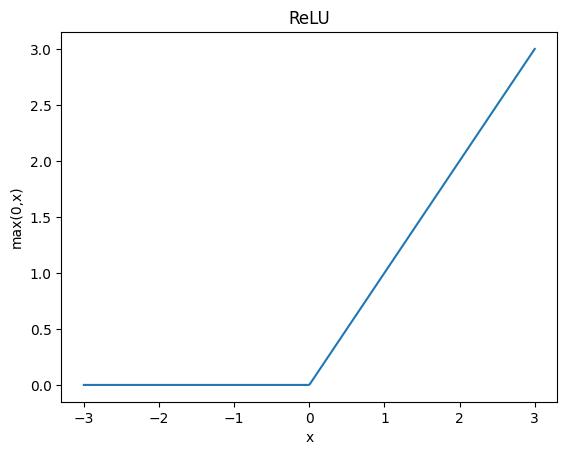

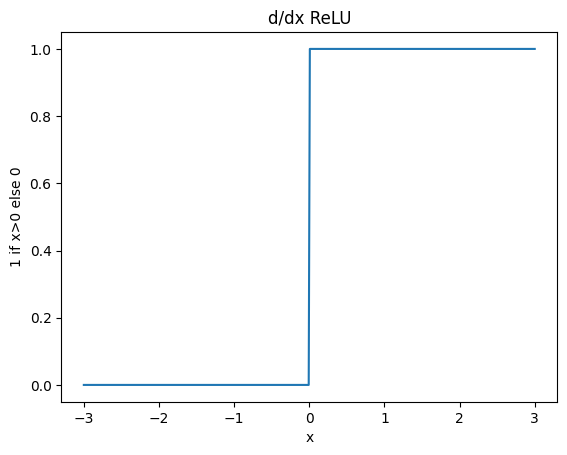

In [136]:
import numpy as np, matplotlib.pyplot as plt
x = np.linspace(-3, 3, 400)
y = np.maximum(0, x)
dy = (x > 0).astype(float)
plt.figure(); plt.plot(x, y); plt.title("ReLU"); plt.xlabel("x"); plt.ylabel("max(0,x)")
plt.figure(); plt.plot(x, dy); plt.title("d/dx ReLU"); plt.xlabel("x"); plt.ylabel("1 if x>0 else 0")
plt.show()


### Exercise - 2D `matmul`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 20-25 minutes on this exercise.
> ```

Implement your version of `torch.matmul`, restricting it to the simpler case where both inputs are 2D (this means we don't need to worry about unbroadcasting or anything).

Note - althought the solution to this exercise is very short (just one line), you may find the actual mathematical derivation a bit tricky. We've given hints to help you, which we recommend using if you're stuck.

In [121]:
def _matmul2d(x: Arr, y: Arr) -> Arr:
    """Matrix multiply restricted to the case where both inputs are exactly 2D."""
    return x @ y


def matmul2d_back0(grad_out: Arr, out: Arr, x: Arr, y: Arr) -> Arr:
    """Backward for Z = X @ Y w.r.t. X (2D only)."""
    return grad_out @ y.T


def matmul2d_back1(grad_out: Arr, out: Arr, x: Arr, y: Arr) -> Arr:
    """Backward for Z = X @ Y w.r.t. Y (2D only)."""
    return x.T @ grad_out



matmul = wrap_forward_fn(_matmul2d)
BACK_FUNCS.add_back_func(_matmul2d, 0, matmul2d_back0)
BACK_FUNCS.add_back_func(_matmul2d, 1, matmul2d_back1)

tests.test_matmul2d(Tensor)

All tests in `test_matmul2d` passed!


## Parameters & Modules

We've now written enough backwards passes that we can go up a layer and write our own `nn.Parameter` and `nn.Module`. These are important abstractions that help us building up neural networks.

Below is a simple implementation of `Parameter`. It is itself a `Tensor`, shares storage with the provided `Tensor` and requires_grad is `True` by default - that's it! Make sure you understand the code being run in this cell to test the functionality of this class.

In [122]:
class Parameter(Tensor):
    def __init__(self, tensor: Tensor, requires_grad=True):
        """Share the array with the provided tensor."""
        return super().__init__(tensor.array, requires_grad=requires_grad)

    def __repr__(self):
        return f"Parameter containing:\n{super().__repr__()}"


x = Tensor([1.0, 2.0, 3.0])
p = Parameter(x)
assert p.requires_grad
assert p.array is x.array
assert (
    repr(p)
    == "Parameter containing:\nTensor(array([1., 2., 3.], dtype=float32), requires_grad=True)"
)
x.add_(Tensor(np.array(2.0)))
assert np.allclose(p.array, np.array([3.0, 4.0, 5.0])), (
    "in-place modifications to the original tensor should affect the parameter"
)

Just like `torch.Tensor`, the `nn.Module` class has a lot of functionality which we mostly don't care about today. We will just implement enough to get our network training.

Below is a simple implementation. We'll explain it a bit below (if you're already experienced in Python then this might be obvious to you and you can skip it).

- **Single-underscore attributes** are a notational convention; they're not treated differently by Python but they're used to indicate that the attribute is private and shouldn't be accessed directly by anyone using the class.
    - `_modules` is a dict mapping module names to module objects. The `modules` method returns an iterator over these modules.
    - `_parameters` is similar, with added recursion to include submodule parameters.
- **Double-underscore attributes** are special methods that determine how your class instance behaves when you use certain syntax.
    - `__call__` determines what the module does when you call it like a function. In this case, `module(*args, **kwargs)` calls `module.forward(**args, **kwargs)` - this is why we only ever need to implement `forward` in the modules we've written so far.
    - `__setattr__` manages attribute setting (i.e. running `module.attr = value` actually calls `module.__setattr__("attr", value)`). The default behaviour is to add the attribute to `self.__dict__`, but we've added custom logic so modules & parameters are also added to `self._modules` and `self._parameters` respectively - this is basically how logic like `module.parameters()` can work.
        - Note that there's a related method `__getattr__` which specifies attribute getting behaviour when lookup in `self.__dict__` fails.

In [123]:
class Module:
    _modules: dict[str, "Module"]
    _parameters: dict[str, Parameter]

    def __init__(self):
        self._modules: dict[str, "Module"] = {}
        self._parameters: dict[str, Parameter] = {}

    def modules(self) -> Iterator["Module"]:
        """Return the direct child modules of this module, not including self."""
        yield from self._modules.values()

    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        """
        Return an iterator over Module parameters.

        recurse: if True, the iterator includes parameters of submodules, recursively.
        """
        yield from self._parameters.values()
        if recurse:
            for mod in self.modules():
                yield from mod.parameters(recurse=True)

    def __setattr__(self, key: str, val: Any) -> None:
        """
        If val is a Parameter or Module, store it in the appropriate _parameters or _modules dict.
        Otherwise, call __setattr__ from the superclass.
        """
        if isinstance(val, Parameter):
            self._parameters[key] = val
        elif isinstance(val, Module):
            self._modules[key] = val
        super().__setattr__(key, val)

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def forward(self):
        raise NotImplementedError("Subclasses must implement forward!")

    def __repr__(self):
        _indent = lambda s_, nSpaces: re.sub("\n", "\n" + (" " * nSpaces), s_)
        lines = [f"({key}): {_indent(repr(module), 2)}" for key, module in self._modules.items()]
        return "".join(
            [
                self.__class__.__name__ + "(",
                "\n  " + "\n  ".join(lines) + "\n" if lines else "",
                ")",
            ]
        )


class TestInnerModule(Module):
    def __init__(self):
        super().__init__()
        self.param1 = Parameter(Tensor([1.0]))
        self.param2 = Parameter(Tensor([2.0]))


class TestModule(Module):
    def __init__(self):
        super().__init__()
        self.inner = TestInnerModule()
        self.param3 = Parameter(Tensor([3.0]))


mod = TestModule()
assert list(mod.modules()) == [mod.inner]
assert list(mod.parameters()) == [mod.param3, mod.inner.param1, mod.inner.param2]
print("Manually verify that the repr looks reasonable:")
print(mod)
print("All tests for `Module` passed!")

Manually verify that the repr looks reasonable:
TestModule(
  (inner): TestInnerModule()
)
All tests for `Module` passed!


### Exercise - implement `Linear`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 20-25 minutes on this exercise.
> ```

Now, let's go one level of abstraction higher and create a `Linear` module. This should inherit from `Module` and have `__init__` & `forward` methods just like your linear module inheriting from `nn.Module` in previous exercises. In fact, your code can probably be extremely similar to the time you implemented `Linear` in the earlier exercises, except you'll need to use methods we've defined already. You should be able to do everything you need in `forward` using just the matmul operator `@`, the transpose operator `.T` (which is equivalent to `.permute(-1, -2)` as you can see in the tensor class above) and standard tensor addition `+`.

To restate the task in case you don't remember it from the previous exercises, you should:

- Define `self.weight` and `self.bias` in `__init__`, with both tensors having a uniform distribution in the range `[-sf, sf]` where `sf = 1/sqrt(in_features)`,
- Write the appropriate affine operation in `forward`, i.e. multiplying by `self.weight` and adding `self.bias` if it exists.

Don't forget to wrap your weights as `Parameter(Tensor(...))`.

In [124]:
class Linear(Module):
    weight: Parameter
    bias: Parameter | None

    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        """
        A simple linear (affine) layer:
          y = x @ weight.T + bias
        weight: (out_features, in_features)
        bias:   (out_features,) or None
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # He/Glorot init not required for tests—any init is fine
        w = Tensor(np.random.randn(out_features, in_features), requires_grad=True)
        self.weight = Parameter(w)

        if bias:
            b = Tensor(np.zeros(out_features, dtype=w.array.dtype), requires_grad=True)
            self.bias = Parameter(b)
        else:
            self.bias = None

    def forward(self, x: Tensor) -> Tensor:
        """
        x: shape (*, in_features)
        return: shape (*, out_features)
        """
        y = x @ self.weight.T   # uses your Tensor matmul & transpose
        if self.bias is not None:
            y = y + self.bias   # broadcast add over leading dims
        return y

    def extra_repr(self) -> str:
        return (
            f"in_features={self.in_features}, out_features={self.out_features}, "
            f"bias={self.bias is not None}"
        )



linear = Linear(3, 4)
assert isinstance(linear.weight, Tensor)
assert linear.weight.requires_grad

input = Tensor([[1.0, 2.0, 3.0]])
output = linear(input)
assert output.requires_grad

expected_output = input @ linear.weight.T + linear.bias
np.testing.assert_allclose(output.array, expected_output.array)

print("All tests for `Linear` passed!")

All tests for `Linear` passed!


Finally, for the sake of completeness, we'll define a `ReLU` module:

In [125]:
class ReLU(Module):
    def forward(self, x: Tensor) -> Tensor:
        return relu(x)

Now we can define a MLP suitable for classifying MNIST, with zero PyTorch dependency!

In [126]:
class MLP(Module):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(28 * 28, 64)
        self.linear2 = Linear(64, 64)
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.output = Linear(64, 10)

    def forward(self, x: Tensor) -> Tensor:
        x = x.reshape((x.shape[0], 28 * 28))
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.output(x)
        return x

### Exercise - implement `cross_entropy`

> ```yaml
> Difficulty: 🔴🔴🟠⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Make use of your integer array indexing to implement `cross_entropy`. See the documentation page [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

We discussed this briefly in the section on indexing earlier, but the kind of indexing you should be doing on your logprobs is `logprobs[range(batch_size), true_labels]`, since this is equivalent to returning the vector of length `batch_size` with elements `[logprobs[0, true_labels[0]], logprobs[1, true_labels[1]], ...]`. Rather than using `range`, you should be using the `arange` function we've provided for you (this is equivalent to torch's `torch.arange` function, and is defined just below the `Tensor` class).

Note - if you're using the `exp` function, it's usually good to make your implementation numerically stable (since taking the exponential of large numbers is prone to overflow). The common solution here is to subtract the maximum value of the tensor from all elements. However, you don't need to worry about that here (consider it a bonus exercise).

In [127]:
def cross_entropy(logits: Tensor, true_labels: Tensor) -> Tensor:
    """Cross-entropy with reduction='none' using a stable log-softmax."""
    # logits: (N, C), labels: (N,)
    N, C = logits.array.shape

    # Stabilize with row-wise max (treated as constant wrt grads).
    row_max = np.max(logits.array, axis=1, keepdims=True)
    z = logits - Tensor(row_max, requires_grad=False)          # (N, C)

    logsumexp = (z.exp().sum(dim=1, keepdim=True)).log()       # (N, 1)
    log_probs = z - logsumexp                                   # (N, C) = log softmax

    # One-hot encode labels (no grad needed through labels)
    labels_np = true_labels.array.astype(int)
    one_hot = Tensor(np.eye(C, dtype=logits.array.dtype)[labels_np], requires_grad=False)  # (N, C)

    # NLL: -log p(true_class)
    nll = -(log_probs * one_hot).sum(dim=1)                    # (N,)
    return nll



tests.test_cross_entropy(Tensor, cross_entropy)

All tests in `test_cross_entropy` passed!


In [138]:
import numpy as np
# Extremely large logits should NOT overflow if CE uses a stable log-softmax
big = Tensor(np.array([[1000., -1000., 0.]]), requires_grad=False)
y   = Tensor(np.array([0]), requires_grad=False)  # <-- make labels a Tensor
loss = cross_entropy(big, y)
print("finite CE:", np.isfinite(loss.array).all(), " (expected: True)")


finite CE: True  (expected: True)


## `NoGrad` context manager

The last thing our backpropagation system needs is the ability to turn it off completely like `torch.no_grad` (or `torch.inference_mode`). We've given you an implementation below, which works by modifying the global `grad_tracking_enabled` variable.

A few notes on the actual python here (again for people who are more familiar with Python and understand it can skip this):

- The `global` keyword is required in order to modify the global `grad_tracking_enabled` variable. We can still reference its value without this keyword, but we wouldn't be able to change it.
- The special `__enter__` and `__exit__` methods are part of the protocol for context managers, which is a more pythonic way of doing this kind of thing. If we have a context manager block like `with NoGrad(): ...`, then we'll run `NoGrad().__enter__()` before any of the code in this block, and `NoGrad().__exit__()` after the block finishes.

In [128]:
class NoGrad:
    """Context manager that disables grad inside the block. Like torch.no_grad."""

    was_enabled: bool

    def __enter__(self):
        """
        Method which is called whenever the context manager is entered, i.e. at the start of the
        `with NoGrad():` block. This disables gradient tracking (but stores the value it had before,
        so we can set it back to this on exit).
        """
        global grad_tracking_enabled
        self.was_enabled = grad_tracking_enabled
        grad_tracking_enabled = False

    def __exit__(self, type, value, traceback):
        """
        Method which is called whenever we exit the context manager. This sets the global
        `grad_tracking_enabled` variable back to the value it had before we entered the context
        manager.
        """
        global grad_tracking_enabled
        grad_tracking_enabled = self.was_enabled


assert grad_tracking_enabled
with NoGrad():
    assert not grad_tracking_enabled
assert grad_tracking_enabled
print(
    "Verified that we've disabled gradients inside `NoGrad`, then set back to its previous "
    "value once we exit."
)

Verified that we've disabled gradients inside `NoGrad`, then set back to its previous value once we exit.


### Exercise - implement `SGD`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> ```

In today's final exercise, you should implement the `SGD` class methods `zero_grad` and `step`. This should be pretty familiar if you've gone through yesterday's exercises on optimizers (although without all the bells and whistles from those exercises, because we're literally just implementing plain SGD with no momentum, weight decay or anything).

Important note - in yesterday's exercises it was important to use inplace operations, so we would actually modify the existing tensor data rather than creating new tensors, and this is also the case here. The inplace operation `+=` is supported, since under the hood this calls `__iadd__` which we've defined in our `Tensor` class (same for subtraction, the underlying method here is `__isub__`). Note that we did discuss earlier how inplace operations are very risky for backprop, this is generally true however here we're using it for parameter updates which aren't meant to be differentiated and which are performed just before zeroing all gradients - this makes it safe in this particular context.

In [129]:
class SGD:
    def __init__(self, params: Iterable[Parameter], lr: float):
        """Vanilla SGD with no additional features."""
        self.params = list(params)
        self.lr = lr
        self.b = [None for _ in self.params]

    def zero_grad(self) -> None:
        """Iterates through params, and sets all grads to None."""
        for p in self.params:
            p.grad = None

    def step(self) -> None:
        """Iterates through params, and updates each of them by subtracting `param.grad * lr`."""
        for p in self.params:
            if p.grad is None:
                continue
            # grad may be a Tensor or ndarray; normalize to ndarray
            grad_arr = p.grad.array if hasattr(p.grad, "array") else p.grad
            p.array = p.array - self.lr * grad_arr



tests.test_sgd(Parameter, Tensor, SGD)

All tests for `SGD` passed!


## Training Your Network

We've already looked at data loading and training loops earlier in the course, so we'll provide a minimal version of these today as well as the data loading code.

In [130]:
train_loader, test_loader = get_mnist()
visualize(train_loader)

Preprocessing data...


Test data: 100%|██████████| 10000/10000 [00:01<00:00, 7609.02it/s]


To finish the day, below is some code for a training/testing loop for MNIST images, which also logs & plots the results.

Note, it's normal to encounter some bugs and glitches at this point - just go back and fix them until everything runs! Because backprop is annoying and fiddly and depends heavily on exactly how the implementation works (with too many edge cases to test all of them), you may have to resort to replacing your code with the reference solution until you find the source of the error - this is a bit frustrating, but we'd be lying if we said ML isn't without its share of slow debugging sessions!

In [139]:
def total_grad_norm(model):
    s = 0.0
    for p in model.parameters():
        if p.grad is not None:
            g = p.grad.array
            s += float((g*g).sum())
    return s**0.5


In [132]:
def train(
    model: MLP,
    train_loader: DataLoader,
    optimizer: SGD,
    epoch: int,
    train_loss_list: list | None = None,
):
    print(f"Epoch: {epoch}")
    progress_bar = tqdm(train_loader)
    for data, target in progress_bar:
        data, target = Tensor(data.numpy()), Tensor(target.numpy())
        optimizer.zero_grad()
        output = model(data)
        loss = cross_entropy(output, target).sum() / len(output)
        loss.backward()
        progress_bar.set_description(f"Train set: Avg loss: {loss.item():.3f}")
        optimizer.step()
        if train_loss_list is not None:
            train_loss_list.append(loss.item())


def test(model: MLP, test_loader: DataLoader, test_accuracy_list: list | None = None):
    test_loss = 0
    test_accuracy = 0
    with NoGrad():
        for data, target in test_loader:
            data, target = Tensor(data.numpy()), Tensor(target.numpy())
            output: Tensor = model(data)
            test_loss += cross_entropy(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            test_accuracy += (pred == target.reshape(pred.shape)).sum().item()
    n_data = len(test_loader.dataset)
    test_loss /= n_data
    print(
        f"Test set:  Avg loss: {test_loss:.3f}, Accuracy: {test_accuracy}/{n_data} "
        f"({test_accuracy / n_data:.1%})"
    )
    if test_accuracy_list is not None:
        test_accuracy_list.append(test_accuracy / n_data)


num_epochs = 8
model = MLP()
start = time.time()
train_loss_list = []
test_accuracy_list = []
optimizer = SGD(model.parameters(), 0.01)
for epoch in range(num_epochs):
    train(model, train_loader, optimizer, epoch, train_loss_list)
    test(model, test_loader, test_accuracy_list)

print(f"\nCompleted in {time.time() - start: .2f}s")

Epoch: 0


Train set: Avg loss: 7.872: 100%|██████████| 118/118 [00:01<00:00, 84.26it/s]


Test set:  Avg loss: 6.206, Accuracy: 3814/10000 (38.1%)
Epoch: 1


Train set: Avg loss: 2.182: 100%|██████████| 118/118 [00:01<00:00, 73.24it/s]


Test set:  Avg loss: 2.895, Accuracy: 2943/10000 (29.4%)
Epoch: 2


Train set: Avg loss: 2.013: 100%|██████████| 118/118 [00:01<00:00, 85.59it/s]


Test set:  Avg loss: 2.437, Accuracy: 2964/10000 (29.6%)
Epoch: 3


Train set: Avg loss: 2.780: 100%|██████████| 118/118 [00:01<00:00, 88.01it/s]


Test set:  Avg loss: 2.361, Accuracy: 2845/10000 (28.4%)
Epoch: 4


Train set: Avg loss: 1.964: 100%|██████████| 118/118 [00:01<00:00, 82.41it/s]


Test set:  Avg loss: 2.624, Accuracy: 2629/10000 (26.3%)
Epoch: 5


Train set: Avg loss: 2.599: 100%|██████████| 118/118 [00:01<00:00, 86.77it/s]


Test set:  Avg loss: 2.250, Accuracy: 3046/10000 (30.5%)
Epoch: 6


Train set: Avg loss: 2.106: 100%|██████████| 118/118 [00:02<00:00, 47.07it/s]


Test set:  Avg loss: 2.137, Accuracy: 3223/10000 (32.2%)
Epoch: 7


Train set: Avg loss: 2.820: 100%|██████████| 118/118 [00:01<00:00, 69.73it/s]


Test set:  Avg loss: 2.149, Accuracy: 3040/10000 (30.4%)

Completed in  13.90s


In [133]:
line(
    [train_loss_list, test_accuracy_list],
    x_max=num_epochs,
    yaxis2_range=[0, 1],
    use_secondary_yaxis=True,
    labels={"x": "Batches seen", "y1": "Cross entropy loss", "y2": "Test accuracy"},
    title="MLP training on MNIST from scratch!",
    width=800,
)

Note - this training loop (if done correctly) will look to the one we used in earlier sections is that we're using SGD rather than Adam. You can try adapting your Adam code from the previous day's exercises, and get the same results as you have in earlier sections.

If it works then congratulations - you've implemented a fully-functional autograd system!

# Bonus

Congratulations on finishing the day's main content! Here are a few more bonus things for you to explore.

### In-Place Operation Warnings

The most severe issue with our current system is that it can silently compute the wrong gradients when in-place operations are used. Have a look at how [PyTorch handles it](https://pytorch.org/docs/stable/notes/autograd.html#in-place-operations-with-autograd) and implement a similar system yourself so that it either computes the right gradients, or raises a warning.

### In-Place `ReLU`

Instead of implementing ReLU in terms of maximum, implement your own forward and backward functions that support `inplace=True`.

### Backward for `einsum`

Write the backward pass for your equivalent of `torch.einsum`.

### Reuse of Module during forward

Consider the following MLP, where the same `nn.ReLU` instance is used twice in the forward pass. Without running the code, explain whether this works correctly or not with reference to the specifics of your implementation.

```python
class MyModule(Module):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(28*28, 64)
        self.linear2 = Linear(64, 64)
        self.linear3 = Linear(64, 10)
        self.relu = ReLU()
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        return self.linear3(x)
```

<details>
<summary>Answer (what you should find)</summary>

This implementation will work correctly.

The danger of reusing modules is that you'd be creating a cyclical computational graph (because the same parameters would appear twice), but the `ReLU` module doesn't have any parameters (or any internal state), so this isn't a problem. It's effectively just a wrapper for the `relu` function, and you could replace `self.relu` with applying the `relu` function directly without changing the model's behaviour.

This is slightly different if we're thinking about adding **hooks** to our model. Hooks are functions that are called during the forward or backward pass, and they can be used to inspect the state of the model during training. We generally want each hook to be associated with a single position in the model, rather than being called at two different points.
</details>

### Convolutional layers

Now that you've implemented a linear layer, it should be relatively straightforward to take your convolutions code from day 2 and use it to make a convolutional layer. How much better performance do you get on the MNIST task once you replace your first two linear layers with convolutions?

### ResNet Support

Make a list of the features that would need to be implemented to support ResNet inference, and training. It will probably take too long to do all of them, but pick some interesting features to start implementing.

### Central Difference Checking

Write a function that compares the gradients from your backprop to a central difference method. See [Wikipedia](https://en.wikipedia.org/wiki/Finite_difference) for more details.

### Non-Differentiable Function Support

Your `Tensor` does not currently support equivalents of `torch.all`, `torch.any`, `torch.floor`, `torch.less`, etc. which are non-differentiable functions of Tensors. Implement them so that they are usable in computational graphs, but gradients shouldn't flow through them (their contribution is zero).

### Differentiation wrt Keyword Arguments

In the real PyTorch, you can sometimes pass tensors as keyword arguments and differentiation will work, as in `t.add(other=t.tensor([3,4]), input=t.tensor([1,2]))`. In other similar looking cases like `t.dot`, it raises an error that the argument must be passed positionally. Decide on a desired behavior in your system and implement and test it.

### `torch.stack`

So far we've registered a separate backwards for each input argument that could be a Tensor. This is problematic if the function can take any number of tensors like `torch.stack` or `numpy.stack`. Think of and implement the backward function for stack. It may require modification to your other code.